# 線形回帰モデル

In [1]:
using Distributions
using Plots

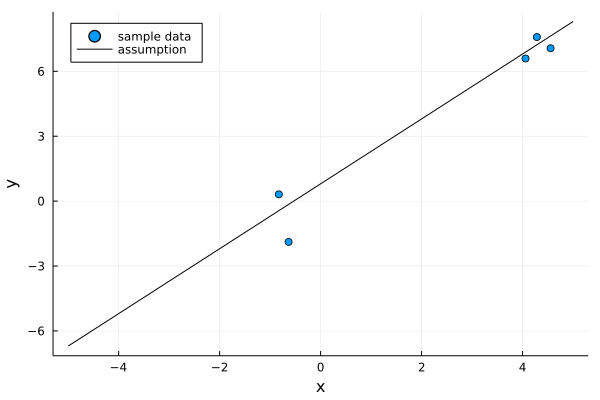

In [2]:
N = 5
true_w1 = 1.5
true_w2 = 0.8
x_data = rand(Uniform(-5, 5), N)
y_data = true_w1 .* x_data .+ true_w2 .+ rand(Normal(0, 1), N)

xs = -5:5
ys = true_w1 .* xs .+ true_w2
scatter(x_data, y_data, xlabel="x", ylabel="y", label="sample data", legend=:topleft)
plot!(xs, ys, color="black", label="assumption")

## Turing.ji

In [3]:
using Turing
using StatsPlots

In [4]:
@model function linear_regression(x, y)
    w1 ~ Normal(0.0, 10.0)
    w2 ~ Normal(0.0, 10.0)
    y ~ MvNormal(w1 * x .+ w2, 1.0)
    return y
end

DynamicPPL.ModelGen{var"###generator#307", (:x, :y), (), Tuple{}}(var"##generator#307", NamedTuple())

In [5]:
model = linear_regression(x_data, y_data)
chain = sample(model, NUTS(), 3000);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/akifumiabe/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


In [6]:
display(chain)

Object of type Chains, with data of type 2000×14×1 Array{Float64, 3}

Iterations        = 1:2000
Thinning interval = 1
Chains            = 1
Samples per chain = 2000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = w1, w2

2-element Vector{ChainDataFrame}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
          w1  1.5434  0.1803    0.0040  0.0066  823.6917  1.0027
          w2  0.4213  0.6149    0.0137  0.0242  810.0006  1.0029

Quantiles
  parameters     2.5%    25.0%   50.0%   75.0%   97.5%
  ──────────  ───────  ───────  ──────  ──────  ──────
          w1   1.1861   1.4232  1.5428  1.6646  1.9071
          w2  -0.7950  -0.0088  0.4221  0.8323  1.6397


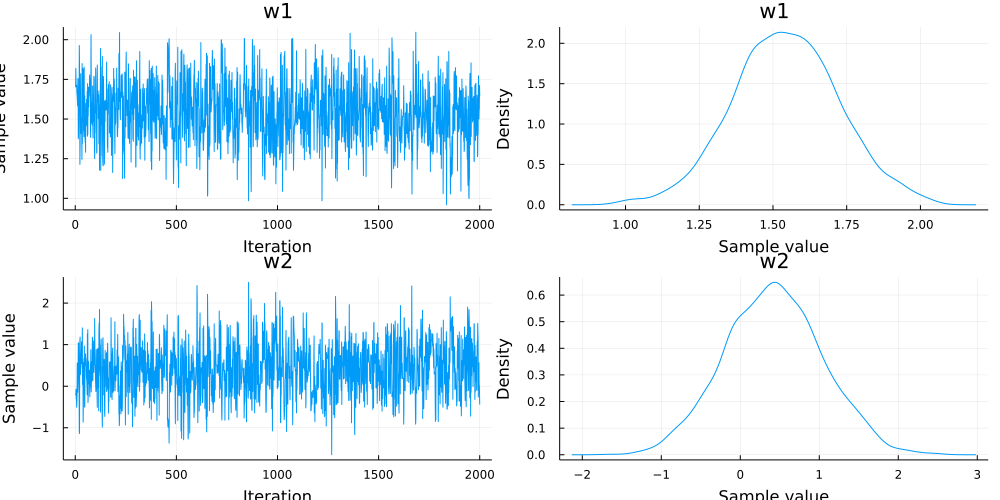

In [7]:
plot(chain)

In [8]:
describe(chain)

2-element Vector{ChainDataFrame}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
          w1  1.5434  0.1803    0.0040  0.0066  823.6917  1.0027
          w2  0.4213  0.6149    0.0137  0.0242  810.0006  1.0029

Quantiles
  parameters     2.5%    25.0%   50.0%   75.0%   97.5%
  ──────────  ───────  ───────  ──────  ──────  ──────
          w1   1.1861   1.4232  1.5428  1.6646  1.9071
          w2  -0.7950  -0.0088  0.4221  0.8323  1.6397


In [9]:
params = get_params(chain)
@show keys(params)

@show _, i = findmax(params[:lp])
@show params[:w1][i]
@show params[:w2][i];

keys(params) = (:hamiltonian_energy, :n_steps, :numerical_error, :max_hamiltonian_energy_error, :hamiltonian_energy_error, :is_accept, :w1, :tree_depth, :log_density, :step_size, :acceptance_rate, :w2, :lp, :nom_step_size)
(_, i) = findmax(params[:lp]) = (-12.844446763027353, CartesianIndex(604, 1))
(params[:w1])[i] = 1.5509668445326772
(params[:w2])[i] = 0.3825568362101348


In [10]:
function prediction(x, y;
        w1 = params[:w1],
        w2 = params[:w2],
        N = length(w1)
    )
    mean(pdf(Normal(w1[n] * x .+ w2[n], 1.0), y) for n in 1:N)
end

prediction(1.0, 1.0)

0.2458039989572114

  0.193214 seconds (689.63 k allocations: 38.236 MiB, 92.95% compilation time)


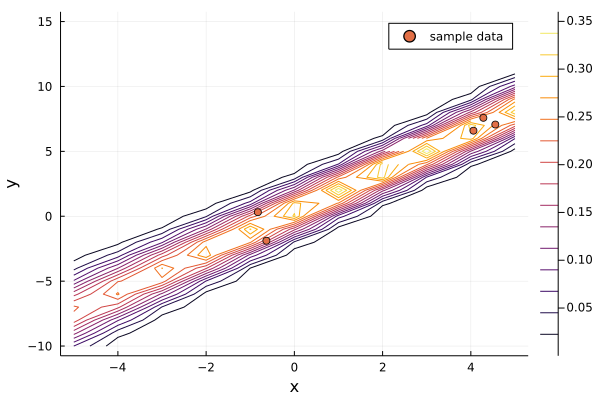

In [11]:
x_new = -5:5
y_new = -10:15
@time prob = prediction.(x_new', y_new)
contour(x_new, y_new, prob)
scatter!(x_data, y_data, xlabel="x", ylabel="y", label="sample data")